### Imports and Setup

In [5]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict

plt.style.use("ggplot")

CWD = Path.cwd()
DATA_DIR: Path = CWD.parent.parent / "data"
SURVEY_CLEAN_PATH: Path = DATA_DIR / "survey" / "[clean]survey_combined.csv"

In [6]:
survey: pd.DataFrame = pd.read_csv(SURVEY_CLEAN_PATH)

### Initial Exploration and Plotting

In [7]:
language_list: list = list(filter(lambda x: "LanguageHaveWorkedWith" in x, survey.columns.to_list()))
language_list = [x.replace("LanguageHaveWorkedWith_", "") for x in language_list]
print(language_list)
print(len(language_list))

['Swift', 'Go', 'Rust', 'Solidity', 'NA', 'PowerShell', 'F#', 'C', 'Julia', 'MATLAB', 'Clojure', 'Assembly', 'Perl', 'JavaScript', 'Elixir', 'Scala', 'Haskell', 'Kotlin', 'VBA', 'TypeScript', 'Java', 'PHP', 'Python', 'C++', 'Objective-C', 'Dart', 'Groovy', 'Delphi', 'Ruby', 'C#', 'HTML/CSS', 'R', 'Lua', 'SQL']
34


In [8]:
# Check if any columns contain nulls
survey.columns[survey.isnull().any()]

Index([], dtype='object')

LanguageHaveWorkedWith_Python                      0.910439
NEWCollabToolsHaveWorkedWith_Visual Studio         0.766311
MiscTechHaveWorkedWith_Pandas                      0.736062
NEWCollabToolsHaveWorkedWith_Visual Studio Code    0.724792
MiscTechHaveWorkedWith_NumPy                       0.721234
LanguageHaveWorkedWith_SQL                         0.613286
ToolsTechHaveWorkedWith_Docker                     0.546263
MiscTechHaveWorkedWith_Torch/PyTorch               0.442467
LanguageHaveWorkedWith_C                           0.436536
LanguageHaveWorkedWith_C++                         0.436536
WebframeHaveWorkedWith_NA                          0.429419
DatabaseHaveWorkedWith_PostgreSQL                  0.418149
MiscTechHaveWorkedWith_TensorFlow                  0.392052
LanguageHaveWorkedWith_Java                        0.362989
OfficeStackAsyncHaveWorkedWith_Confluence          0.341637
LanguageHaveWorkedWith_R                           0.329775
NEWCollabToolsHaveWorkedWith_PyCharm    

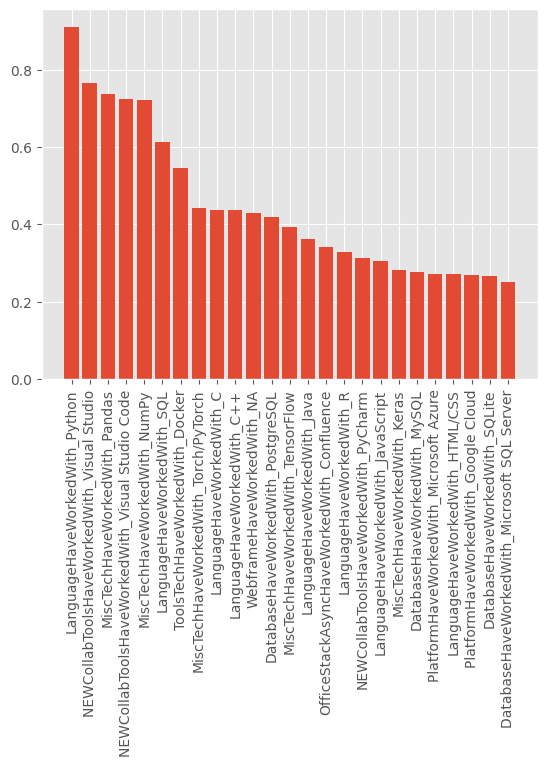

In [9]:
def plot_counts(df: pd.DataFrame) -> None:
    # Get top 25 skills and plot the count across the dataframe as a percentage
    row_count = len(df)
    df = df.drop("ConvertedCompYearly", axis=1)
    y = (
        (df.sum() / row_count)
        .sort_values(ascending=False)
        .iloc[:25]
    )
    x = y.index.to_list()
    print(y)
    points = zip(x, y)
    plt.bar(x=x, height=y)
    plt.xticks(rotation=90)
    plt.show()

plot_counts(survey)

### Training Simple Models

In [10]:
from sklearn.model_selection import train_test_split
X = survey.copy().drop("ConvertedCompYearly", axis=1)
y = survey["ConvertedCompYearly"]  # Target variable(s)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid_lr = [
    {
        'fit_intercept': [True, False],
        'positive': [True],  # Constrain coefficients to be positive
    }
]
grid_search_lr = GridSearchCV(LinearRegression(), param_grid=param_grid_lr, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

param_grid_ridge = [
    {
        'fit_intercept': [True, False],
        'positive': [True],
        'alpha': [0.1, 1, 10, 100]  # Regularization strength (only for Ridge)
    }
]
grid_search_ridge = GridSearchCV(Ridge(), param_grid=param_grid_ridge, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)

param_grid_elastic = [
    {
        'alpha': [0.01, 0.1, 1],  # Regularization strength
        'l1_ratio': [0.3, 0.5, 0.7],  # L1/L2 mix (0=L2, 1=L1)
        'positive': [True],
        'max_iter': [1000, 5000, 10000]  # Ensure convergence for large datasets
    }
]
# Commenting out elastic net as not sure it makes sense to eliminate skills
grid_search_elastic = GridSearchCV(ElasticNet(), param_grid=param_grid_elastic, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_elastic.fit(X_train, y_train)


best_model = max([
    grid_search_lr, grid_search_ridge, #grid_search_elastic
    ], key=lambda gs: gs.best_score_)
lreg = best_model.best_estimator_

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 100], 'max_features': [100, 200, 312]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 100], 'max_features': [100, 200, 312]},
]

rf = RandomForestRegressor()
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', 
    n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
rf = grid_search.best_estimator_

### XGBoost

In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1],  # Step size shrinkage
    'max_depth': [3, 6],  # Tree depth (controls complexity)
    'subsample': [0.8],  # Fraction of samples per tree
    'colsample_bytree': [0.8],  # Fraction of features per tree
}

grid_search_xgb = GridSearchCV(
    xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1, verbose=1
)

grid_search_xgb.fit(X_train, y_train)

print("Best Parameters:", grid_search_xgb.best_params_)
print("Best R² Score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best R² Score: -0.21382209260238416


### Model Evaluation

In [15]:
from sklearn.model_selection import cross_val_score

def display_scores(scores: np.array):
    return f"Scores: {scores}\nMean: {scores.mean()}\nStandard deviation: {scores.std()}"


# Evaluate linear regression performance
lin_reg_rmse_scores = np.sqrt(-cross_val_score(lreg, X_train, y_train,
                        scoring="neg_mean_squared_error", cv=10))
print(f"Linear Regression:\n{display_scores(lin_reg_rmse_scores)}")

# Evaluate random forest performance
forest_reg_rmse_scores = np.sqrt(-cross_val_score(rf, X_train, y_train,
                            scoring="neg_mean_squared_error", cv=10))
print(f"Random Forest:\n{display_scores(forest_reg_rmse_scores)}")

# Evaluate XGBRegressor performance
xgb_reg_rmse_scores = np.sqrt(-cross_val_score(xgb_r, X_train, y_train,
                            scoring="neg_mean_squared_error", cv=10))
print(f"XGBRegressor:\n{display_scores(xgb_reg_rmse_scores)}")

Linear Regression:
Scores: [810357.44975904 227977.54703041 132778.05309838 155472.12616588
 106390.01956236 125363.92038946 501548.70244542 147447.06717627
 143674.56160024 853601.06628657]
Mean: 320461.05135140347
Standard deviation: 278047.7557461492
Random Forest:
Scores: [829374.12020662 358201.81143971 153843.23405303 212439.30214882
 204072.92432934 148980.29592352 482115.38572624 215133.54852649
 308493.11233436 859898.9779805 ]
Mean: 377255.2712668626
Standard deviation: 252765.82014291926
XGBRegressor:
Scores: [823891.45118937 622652.5584717  135758.41930163 231955.38891636
 247854.38764192 149400.73941278 514383.54230825 342439.30483731
 485878.65000647 867863.36998681]
Mean: 442207.781207261
Standard deviation: 252610.79572592743


### Summary
* It appears from this preliminary exploration that using these primitive methods it is **not possible** to determine a meaningful relationship between individual skills and salary
* RMSE mean and stdev values this large indicate a very poor fit
* In the future it may be worth looking into more complex approaches, perhaps including using **embeddings** for feature selection, followed by a neural network
* The outputs of this black box model could then be interpreted using **SHAP**
* Alternatively a mixed effects model could be investigated to account for some of the interactions/ noise of other factors in the dataset including age, years of experience and country, which likely have a greater impact on salary than skills

### What's next?
* Next piece of exploration will be looking into the salary scrape from LinkedIn, to gain insights into what the job market is looking for in this sector